<center><h1>ECMM466: Social Networks and Text Analysis<h1\><center\>

# <center> Coursework 1

**SID:** 710003602

In [1]:
# import the needed libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import patches
import powerlaw
from pylab import rcParams
from collections import Counter
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
import matplotlib
import matplotlib.colors as mcolors
from itertools import chain
import community

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Network Analysis

### 1.a Load the Network

In [2]:
Gx = nx.read_edgelist('infect-dublin.edges')

### 1.b Adjacency Matrix

In [3]:
# plotting the adjacency matrix of infect-dublin
def plot_adj_matrix(G):
    '''Plot adjacency matrix of a graph
    
    Params:
    -------
    G: Graph
    '''
    
    G_adj = nx.to_numpy_matrix(G)
    rcParams['figure.figsize'] = (10,10)
    plt.title('infect-dublin Adjacency Matrix', fontsize = 'x-large')
    plt.ylabel('nodes idx', fontsize = 'x-large')
    plt.xlabel('nodes idx', fontsize = 'x-large')
    plt.imshow(G_adj)

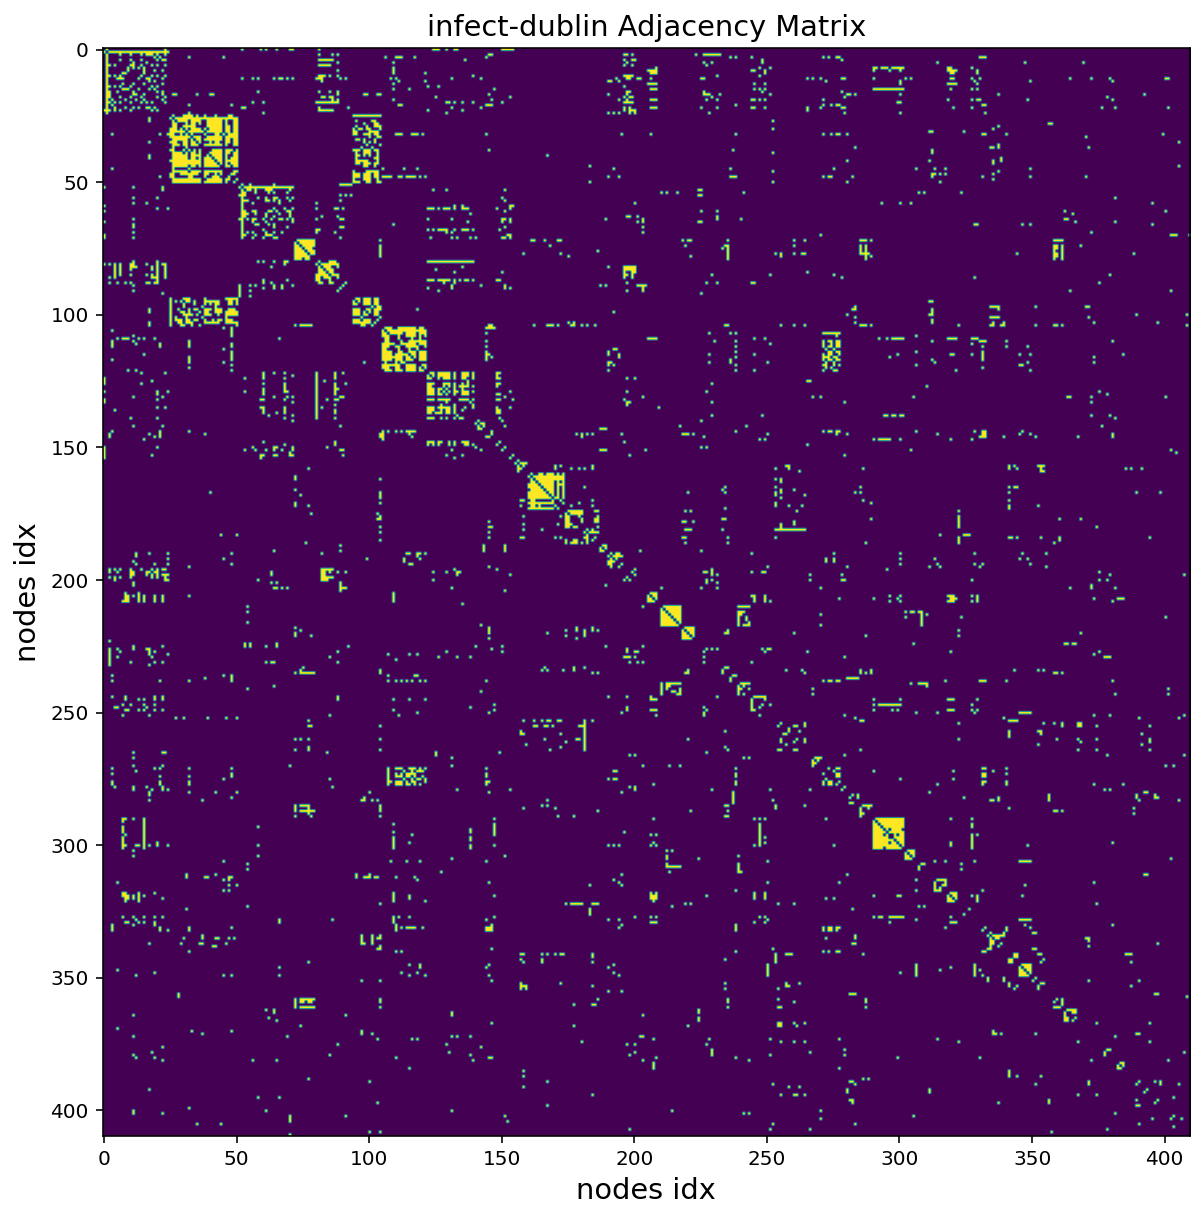

In [4]:
plot_adj_matrix(Gx)

### 1.c Degree Distribution Plot

In [5]:
def plot_degree_distribution(G):
    '''Plot the degree distribution of a plot
    
    Params:
    ------
    G: Graph
    '''

    # count the degrees for the network
    degree_G = sorted([d for n, d in G.degree()], reverse = True)
    degree_count = Counter(degree_G)
    
    # create a list of degrees and a respective counts list
    deg, count = zip(*degree_count.items())

    # plot the degree distribution
    fig, ax = plt.subplots()
    rcParams['figure.figsize'] = (11,8)
    plt.bar(deg,count)
    plt.title('Degree Distribution')
    plt.xlim((0,60))
    plt.xlabel('Degree')
    plt.ylabel('Count')

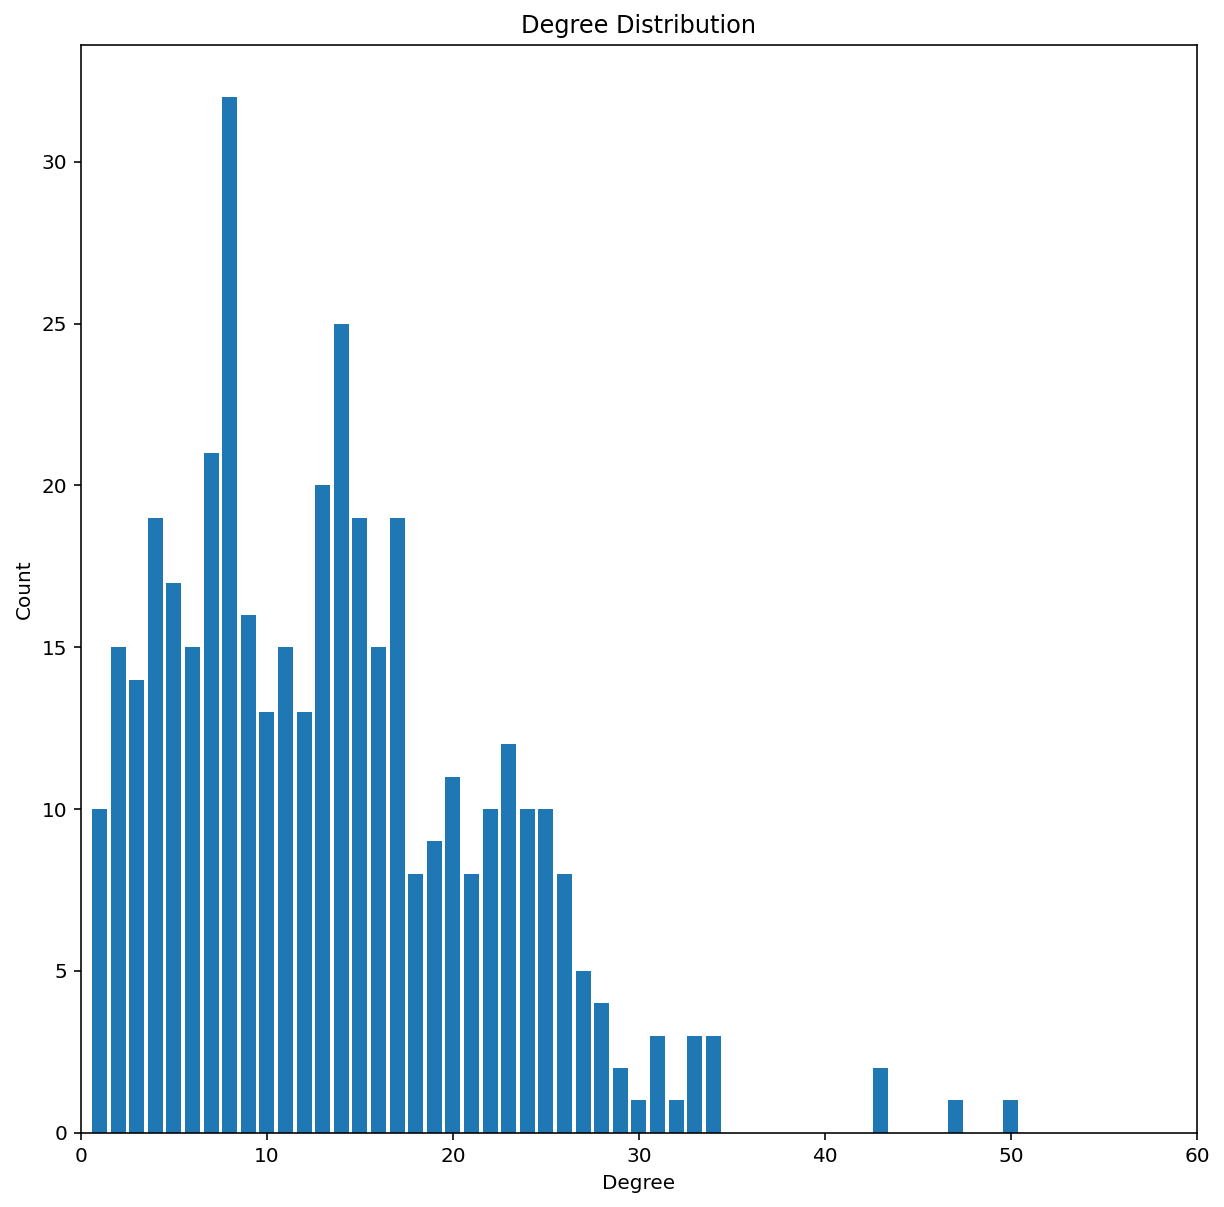

In [6]:
plot_degree_distribution(Gx)

### 1.d Degree Sequence

In [7]:
def plot_degree_sequence_powerlaw(G):
    '''This function fits the powerlaw distribution to our current data, plot pdf and ccdf for 
    the fitted powerlaw and G degree distribution (from the degree sequence)
    
    Params:
    -------
    G: networkx
    '''
    
    degree_seq_G = sorted([d for n, d in nx.degree(G)])
    
    # get counter from degree sequence
    degree_seq_count = Counter(degree_seq_G)

    rcParams['figure.figsize'] = (6,6)
    fit = powerlaw.Fit(list(degree_seq_count.values()), xmin = 10) # even with changing xmin, the result is poorly fit
    
    fig2 = fit.plot_ccdf(color='b', linestyle='dashed')
    fit.power_law.plot_ccdf(color='b', alpha=0.6, ax = fig2)
    
    fit.plot_pdf(color='r', linestyle='dashed', ax = fig2)
    fit.power_law.plot_pdf(color='r', alpha=0.6, ax = fig2)

    plt.legend(['Data CCDF','fit CCDF', 'Data pdf', 'fit PDF'], fontsize = 'x-large')
    plt.xlabel('Degree', fontsize = 'x-large')
    plt.ylabel('p(X), p(X≥x)', fontsize = 'x-large')
    plt.show()


/Users/anis.bouhamadouche/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/Users/anis.bouhamadouche/opt/anaconda3/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /


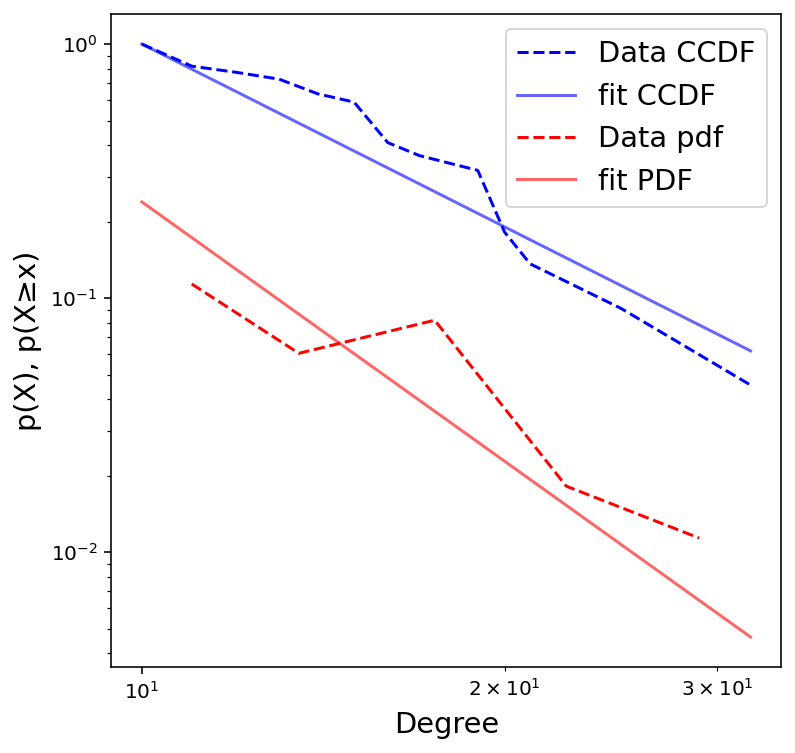

In [8]:
plot_degree_sequence_powerlaw(Gx)

In this case, the degree distribution of this network doesn't follow a powerlaw distribution. From the previous plot, we see that it fit poorly to the data. I would still say that the number of nodes and links in our network are small, one of the hypothesis could be that if the network grew bigger in time (naturally, following the infection), it may lead to a clear distribution that allows us to have a further comment on this.

### 1.e Assortative or Disassortative?

In [9]:
r = nx.degree_assortativity_coefficient(Gx)
print(r)

0.22575194757837194


From the **degree correlation**, we can say the network is **Assortative**. We can expect some of the nodes connecting to nodes having the same degree. This translates to the fact that people that were in contact with people that have a large number of people are most likely to be in contact with the same large number of people. This suggests that the infection will spread rapidely within the nodes with high degrees to other nodes with high degrees, a vaccination campaign can be more effective if those nodes with high degrees were targeted. 

## 2. Centrality and Community Detection

### 2.a Centralities

**1. Definition**
- ***Degree Centrality***: is a measure that captures how connected the node is within the network. It is simply the number of links for a given node (direct links).
- ***Eigenvector Centrality***: is a measure of importance of a given node within a network. This measure captures what the other centralities fail to measure. Important nodes are given high values, their respective neighbours may also receive a relatively high value due to their direct connection to that node. This is a measures that gives the influece of the node over the entire network not only over direct connections.

**2. Difference**
The difference between the Degree centrality and Eigenvector centrality is that degree centrality is a measure of direct influece of nodes over their neighbours (or neighbours over a given node), whereas Eigenvector centrality measure the importance of individual nodes within the entire network and potential influence they could cause in the network (measures the node's degree and the degree of its neighbours). Degree centrality only takes into account the number of links for a node while Eigenvector centrality makes use of the adjacency matrix 

**3. Examples**
- Eigenvector Centrality can be used for example on social media to determine the importance of a certain user for example to influence public opinion (taking other attributes into account), another main application of this measure is through it's extention ***PageRank*** that is used by Google to rank web pages. [[reference]](http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html)
- Degree centrality is a blind measure of popularity in the context of Social Network Analysis, it can serve to measure the popularity of a specific person without looking at the important of their connections (how important people connected to them are - eigenvector centrality takes this into account)

The usage of both centrality measures really depends on the subject we are studying, in the virus contamination case, degree centrality would be usefull to determine which nodes can spread the virus (or are more likely to get contaminated) so we can act on it. Eigenvector centrality, on the other hand, can be very useful in terms of determining the influence of a node and its importance in a network, such applications are very useful in social network analysis.

### 2.b.i Closeness Centrality

In [10]:
def centrality_closeness(G):
    '''This function computes closeness centrality from scratch without networkx functions
    
    Params:
    ------
    G: networkx graph
    
    Returns:
    -------
    closeness_cent: numpy array containing closeness centrality of all nodes in the graph G
    '''
    
    # loading the graph as a matrix in the scipy module
    graph = csr_matrix(nx.to_numpy_matrix(G))
    
    G_nodes = G.nodes() # get the list of nodes
    shortest_paths = [] # empty list used to append the sum of shortest paths for each node
    
    # iterate over each node and compute the distance of the shortest path to all of the possible nodes
    for count in range(len(G_nodes)):
        
        dist = dijkstra(csgraph=graph, directed=False, indices=count, return_predecessors=False)
        shortest_paths.append(sum(dist))

    return 1/np.array(shortest_paths)*len(G_nodes)

In [11]:
closeness_cent = centrality_closeness(Gx)

In [12]:
# computing the squared error to check beween the computer closeness centrality and the one provided by networkx 
sum((closeness_cent - list(nx.closeness_centrality(Gx).values()))**2)/len(Gx.nodes())

4.830780318924065e-07

### 2.b.ii Closeness Centrality

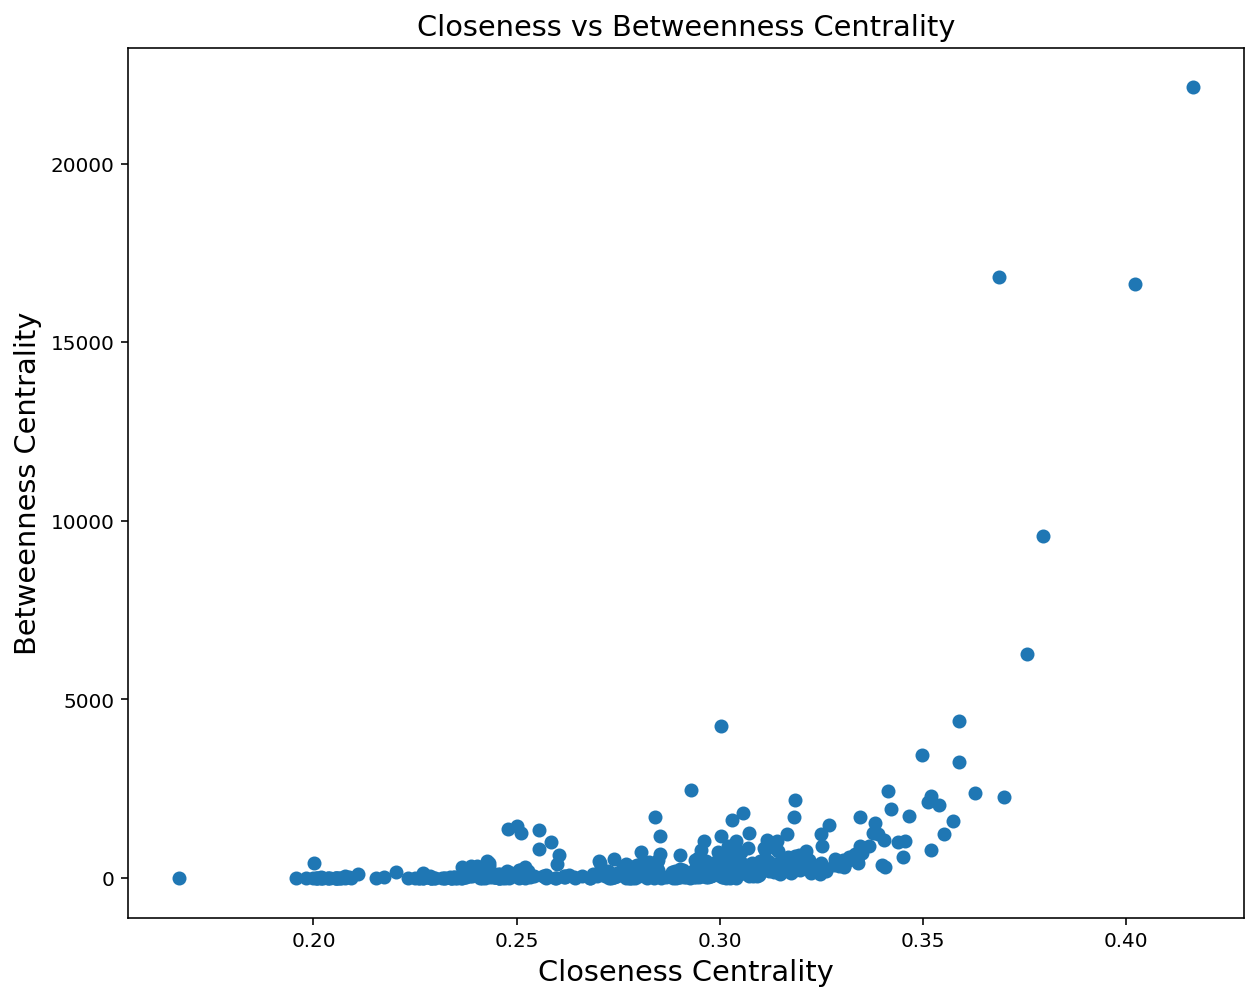

In [13]:
rcParams['figure.figsize'] = (10,8)
plt.title("Closeness vs Betweenness Centrality", fontsize = 'x-large')
plt.xlabel('Closeness Centrality', fontsize = 'x-large')
plt.ylabel('Betweenness Centrality', fontsize = 'x-large')
plt.scatter(closeness_cent, nx.betweenness_centrality(Gx, normalized=False).values())

From the scatter plot above, we can see that somehow there is a positive correlation between betweenness centrality and closeness centrality. One of the main reasons this correlation between these two centrality measures exists is their dependency on shortest paths, but this is not always the case [[reference](https://www.researchgate.net/publication/282927391_Maintaining_the_duality_of_closeness_and_betweenness_centrality)]. Both betweenness and closeness centralities help explain the infection in the network. The closer the person the more vulnerable other nodes become. An infected node having a high betweenness centrality also poses a threat on the other nodes(or is vulnerable) as more shortest paths are passing through it. The below cell confirms that the two metrics are positively correlated.

In [14]:
betweenness_cent = list(nx.betweenness_centrality(Gx).values())
np.corrcoef(closeness_cent,betweenness_cent)

array([[1.        , 0.43010757],
       [0.43010757, 1.        ]])

### 2.c Centrality Measure

Choosing an influencer based on single centrality measure is a little bit challenging as every centrality metric covers something that other measures fail to capture. Degree centrality measures the centrality of a given node based on the number of direct links. This translates the number of followers for that specific influencer (in-degree for followers and out-degree for following for example). Howerver, having a large number of followers does not guarantee a good advertisement campaign. Betweeness centrality can measure the flow of information (post appearance let's say). A node with high betweeness centrality may be critical since it may come between the influencer and a cluster of users, any disconnection between that profile and the chosen influence will cause the entire cluster to miss the content. A more relevent measure is ***PageRank***, this can measure how much engagement the influencer creates on the platform and can measure the amount of interaction the node has.

In [15]:
def page_rank_influencer(G):
    '''Compute the PageRank and plot the graph with the node with highest PageRank highlighted
    
    Params:
    ------
    G: networkx graph
    '''
    
    # compute PageRank for each node in the graph
    page_rank_dict = nx.pagerank(G)
    node, prank = zip(*page_rank_dict.items()) 
    
    # get the node having the largest PageRank centrality
    influencer = node[np.argmax(prank)]

    rcParams['figure.figsize'] = (15,10)
    # set the layout of the graph
    pos = nx.kamada_kawai_layout(G)

    # draw the network
    nodes = nx.draw_networkx_nodes(G, pos, node_size=20, cmap=plt.cm.plasma, node_color = prank)
    nx.draw_networkx_edges(G,pos, alpha = 0.2, edge_color='grey')
    
    # add the influencer node
    nx.draw_networkx_nodes(G,pos,node_size=100, nodelist=[influencer], node_color='darkgreen')
    
    # setup the colorbar
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.05, linscale=1))
    cbar = plt.colorbar(nodes)
    cbar.set_label('PageRank', rotation=270, fontsize= 'x-large')
    
    plt.title('PageRank and Influencer Selection', fontsize ='x-large')
    plt.axis('off')
    plt.show()
    
    return influencer

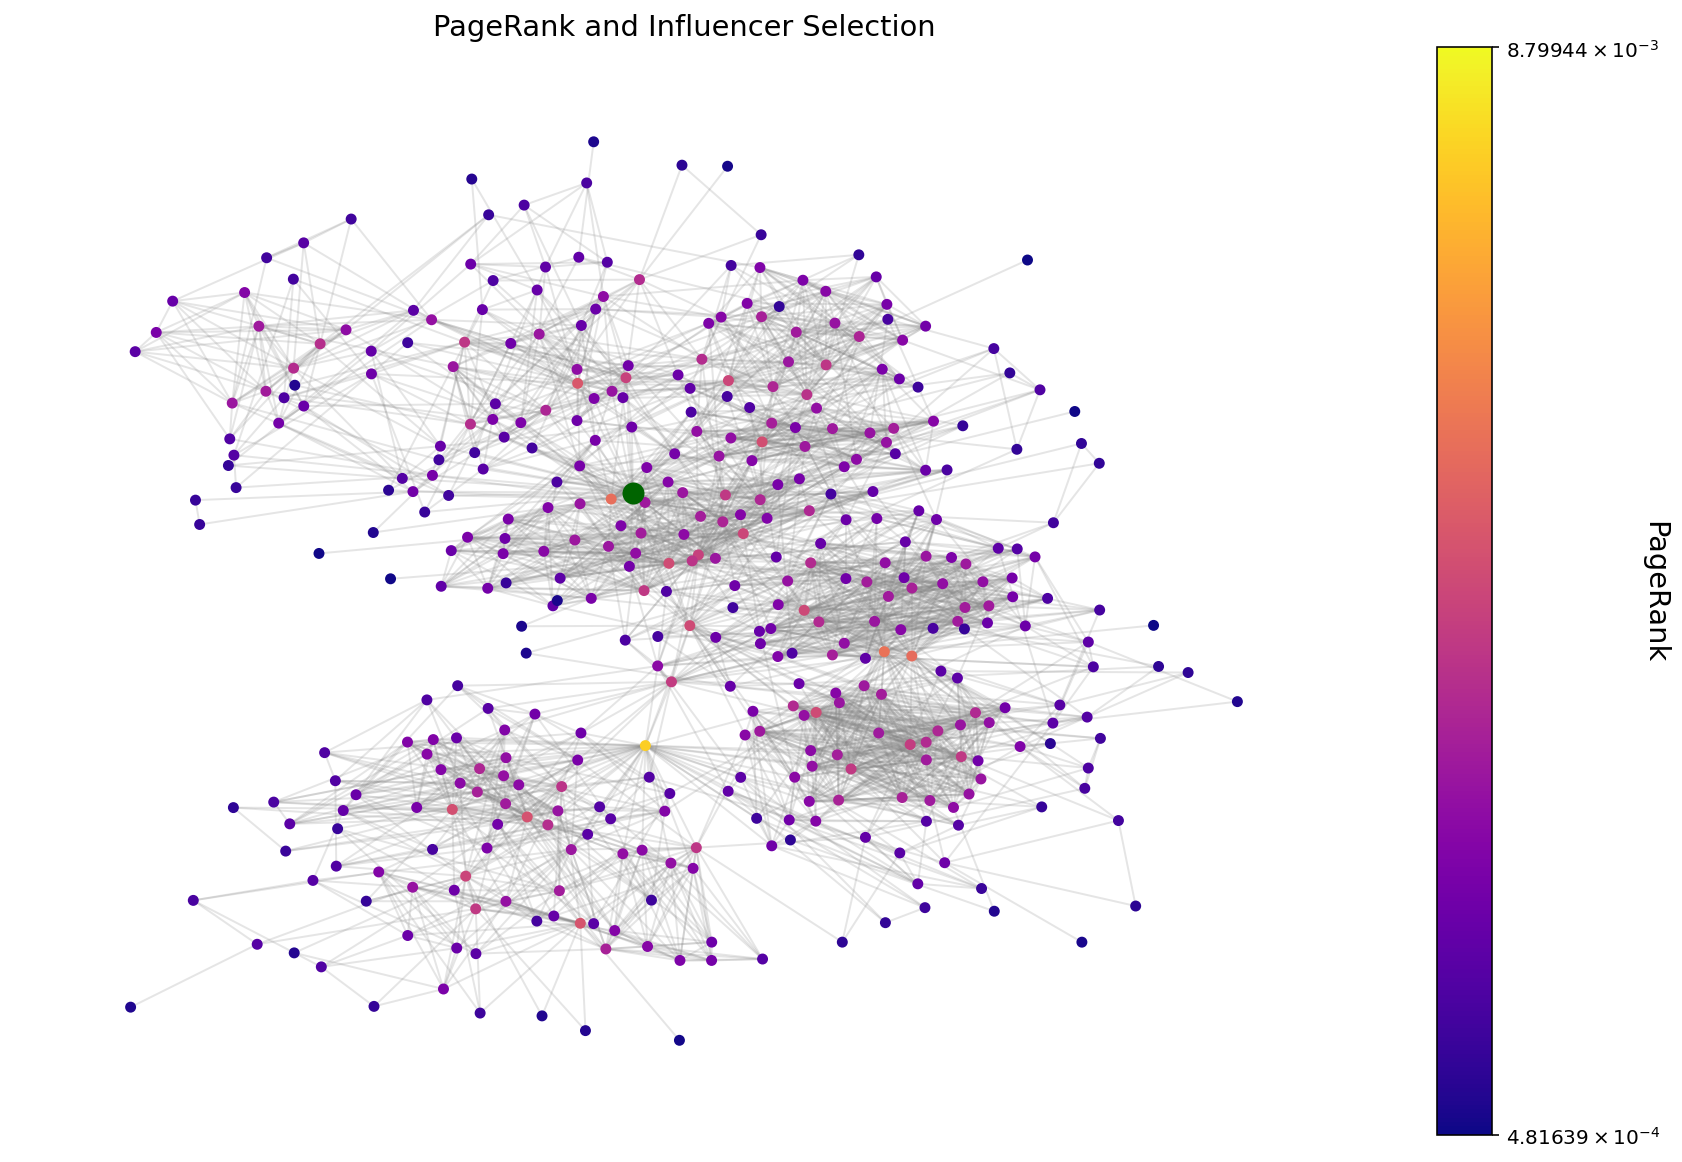

In [16]:
influencer = page_rank_influencer(Gx)

### 2.d Influencer Ego network

In [17]:
def Draw_ego_network(G, layout, node_id, max_interaction_dist):
    '''This function will draw the ego network of the selected node_id of the graph G having different
    interaction levels with a different color. The plot will depend on the maximum interaction distance.
    
    Params:
    ------
    G: networkx Graph
    
    layout: networkx.layout object specifying the positions of each node
    
    node_id: int specifying the selected node
    
    max_interaction_dist: int specifying the different levels of ego network we wish to highlight
    '''
    
    rcParams['figure.figsize'] = (15,10)
    # use cmap to color ego network
    cmap = matplotlib.colors.ListedColormap(plt.cm.Set2([i for i in range(max_interaction_dist+1)]))
    # draw the network in gray initially
    nodes = nx.draw_networkx_nodes(G, 
                                   pos = layout, 
                                   node_color='black', 
                                   node_size=10, alpha=0.4)
    nx.draw_networkx_edges(G,
                           pos=layout, 
                           edge_color='gray', 
                           alpha=0.1)
    
    # dictionary that stores nodes and their edges in each level (key)
    dict_levels = {0: [[node_id], list(G.edges(node_id))]}
    
    
    current_level_neighbours = []
    for level in range(max_interaction_dist): 
        
        # get the neighbours at the current level
        for nn in dict_levels[level][0]:
            neighbours = [n for n in G.neighbors(nn)]
            current_level_neighbours.append(neighbours)
            
            dict_levels[level+1] = [list(chain.from_iterable(current_level_neighbours)),
                                   list(G.edges(list(chain.from_iterable(current_level_neighbours))))]
    
    # draw the last level nodes first
    nx.draw_networkx_nodes(G,
                          pos = layout,
                          nodelist=dict_levels[max_interaction_dist][0],
                          node_size=10,
                          node_color=cmap(max_interaction_dist))
    
    for i in reversed(range(max_interaction_dist)):
        node_size = 10
        if i == 0:
            node_size = 100
        nx.draw_networkx_edges(G,
                              pos = layout,
                              edgelist=dict_levels[i][1],
                              edge_color=cmap(i))
        nx.draw_networkx_nodes(G,
                              pos = layout,
                              nodelist=dict_levels[i][0],
                              node_size=node_size,
                              node_color=cmap(i))
        
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = plt.colorbar(sm, ticks = np.linspace(0,1, max_interaction_dist+1))
    cbar.ax.set_yticklabels([i for i in range(max_interaction_dist+1)])
    plt.axis('off')
    plt.title('Ego Network for Chosen Influencer', fontsize = 'x-large')
    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


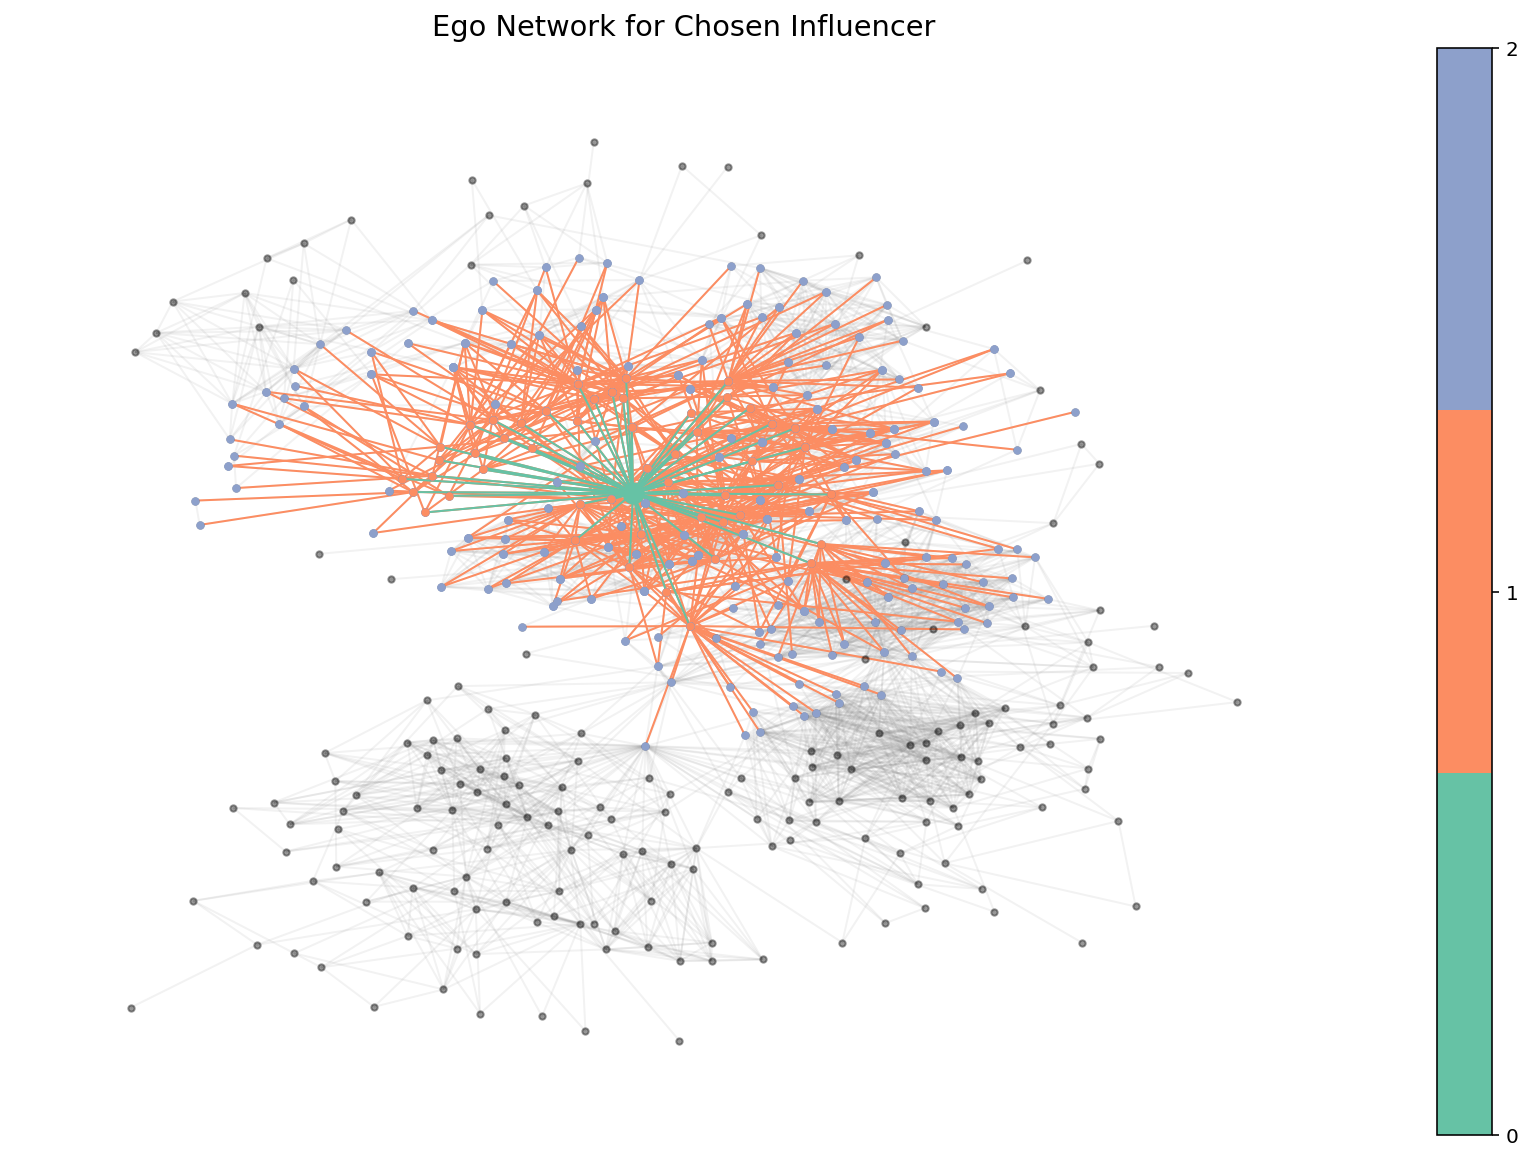

In [18]:
Draw_ego_network(Gx, nx.kamada_kawai_layout(Gx, scale=3), influencer, 2)

### 2.e Community Detection

Choosing the right centrality metric is critical to choose which node is selected as a garage for delivery. The choice of metric depends on different assumptions. For instance, if the company's strategy is to reduce carbon footprint we may be using less trucks (or lack of resources), this means that degree centrality will be very relevant here. Under the assumption that we want to pick a garage that is closer to most of nodes, ***closeness centrality*** is the most relevent. [[refrence]](https://www.researchgate.net/figure/Comparing-the-delivery-ratio-by-different-centrality-metrics_fig4_281315168)

In [19]:
def community_detection_plot(G):
    '''Detect communities based on Louvain algorithm and draw the network with each of the largest communities
    having a different color and highlighting both garages in black after selecting them based on closeness 
    centrality computer from both comppu
    
    Parameters:
    ----------
    G: networkx Graph'''
    
    communities = community.best_partition(Gx)
    
    # select the two larges communities
    nodes, com = zip(*communities.items())
    sorted_communities = {k: v for k,v in sorted(Counter(com).items(), key = lambda item: item[1],reverse=True)}
    largest_com = list(sorted_communities.keys())[:2]

    
    # get indeces of nodes in the first and second largest community (to reduce loops and for the purpose of this 
    # coursework) I have repeated the code for both communities (since we only have two), otherwise, I would use a 
    # for loop according to an input "number of garages" to make the code scalable
    com_idx1 = [i for i, c in enumerate(com) if c == largest_com[0]]
    nodes_com1 = [nodes[i] for i in com_idx1]
    com_idx2 = [i for i, c in enumerate(com) if c == largest_com[1]]
    nodes_com2 = [nodes[i] for i in com_idx2]
    
    
    plt.title("Largest Communities with Garages", fontsize='x-large')
    plt.axis('off')
    pos = nx.spring_layout(G)
    # plot the graph and the two communities
    nds = nx.draw_networkx_nodes(G, pos = pos, node_size=20, node_color='gray', alpha = 0.4)
    nx.draw_networkx_edges(G,pos, alpha = 0.2, edge_color='grey')
    
    # draw the first largest community
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color = 'r', nodelist = nodes_com1)
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color = 'y', nodelist = nodes_com2)
    
    # we need to compute closeness centrality only within the community without taking other nodes into account
    # we first copy the graph and remove nodes that we not within the two communities
    G_copy = G.copy()
    idx_other_com = [i for i, c in enumerate(com) if c not in largest_com]
    G_copy.remove_nodes_from([nodes[i] for i in idx_other_com])
    
    closeness_cent = nx.closeness_centrality(G_copy)
    closeness_cent = {k: round(v,2) for k,v in nx.closeness_centrality(G_copy).items()}
    
    # get the largest node with largest closeness centrality for both communities
    garage2 = nodes_com2[np.argmax([closeness_cent[i] for i in nodes_com2])]
    garage1 = nodes_com1[np.argmax([closeness_cent[i] for i in nodes_com2])]
    
    # draw the values of closeness centrality on both garages
    nx.draw_networkx_labels(G_copy, 
                            pos, 
                            labels = {garage1:closeness_cent[garage1], garage2:closeness_cent[garage2]}, 
                            font_color = 'white', 
                            font_size=10, 
                            font_weight='bold')
    
    # draw both garages in black
    nx.draw_networkx_nodes(G, pos, node_size=600, node_color = 'black', nodelist = [garage1, garage2])

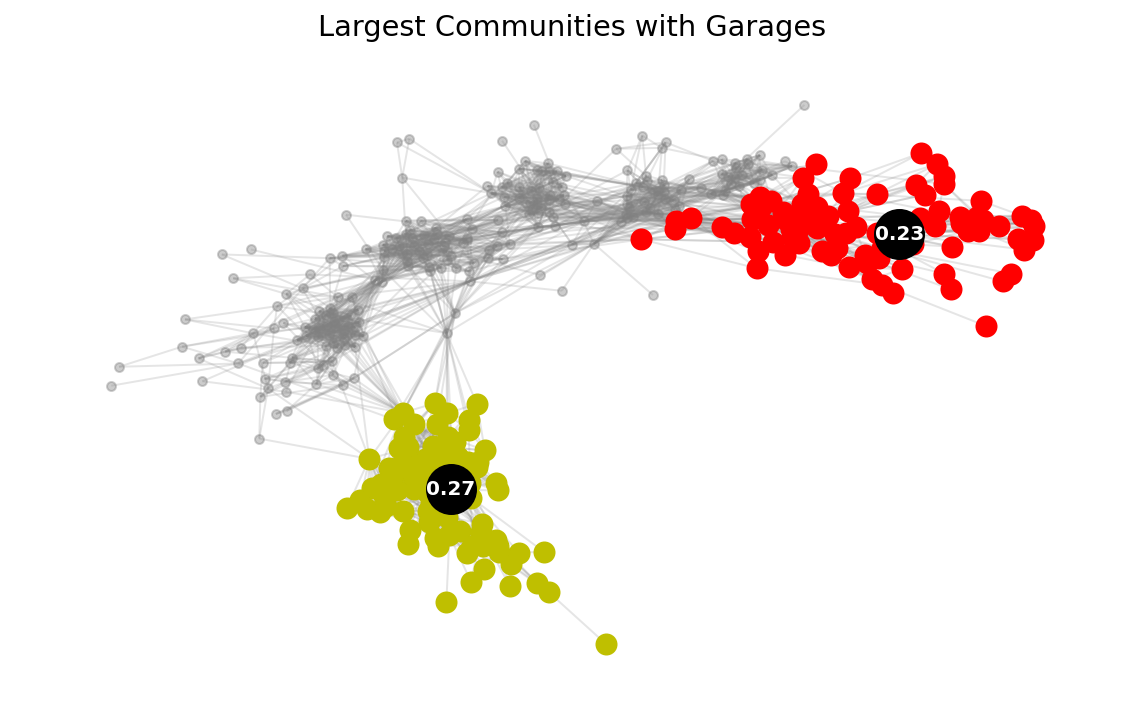

In [37]:
community_detection_plot(Gx)

### 2.f Adjacency matrix of the Community Detection

In [21]:
def plot_adj_comm(G, metrics):
    '''Draw the reordered adjacency matrix of G based on communities detected using metrics
    Parameters:
    ----------
    G: networkx graph
    metrics: dictionary having nodes and their respective communities'''
    
    nodes, com = zip(*metrics.items())
    sorted_communities = {k: v for k,v in sorted(Counter(com).items(), key = lambda item: item[1],reverse=True)}
    sections = sorted_communities.values()
    
    # sort nodes in such a way adjacent rows/columns should belong to the same community
    sorted_nodes = []
    m = []
    for c in sorted_communities.keys():
        for n, cm in metrics.items():
            if cm == c:
                sorted_nodes.append(n)
                m.append(cm)

                
    ax = plt.gca() # get the current access to be used for adding the squares
    
    # colorbar configuration
    color_dict = {0:'white', 1:'blue'}
    cm = matplotlib.colors.ListedColormap([color_dict[x] for x in color_dict.keys()])
    norm_b = np.sort([*color_dict.keys()]) + 0.5
    norm_b = np.insert(norm_b, 0, np.min(norm_b) - 1.0)
    norm = matplotlib.colors.BoundaryNorm(norm_b, 2, clip=True)
    
    # sort adjacency matrix based on sorted nodes (according to communities)
    adj_mat = nx.to_numpy_array(G, nodelist=sorted_nodes)
    adj_plot = plt.imshow(adj_mat, cmap = cm, norm=norm)
    
    # add a red square after each portion (number of nodes per community)
    current = 0
    for section in sections:
        ax.add_patch(patches.Rectangle((current, current),
                                          section,
                                          section,
                                          facecolor="none",
                                          edgecolor='red',
                                          linewidth="1"))
        current += section
    rcParams['figure.figsize'] = (10,10)
    cbar = plt.colorbar(adj_plot, ticks = [0,1])
    cbar.ax.set_ylabel('Links', rotation=270, fontsize = 'x-large')

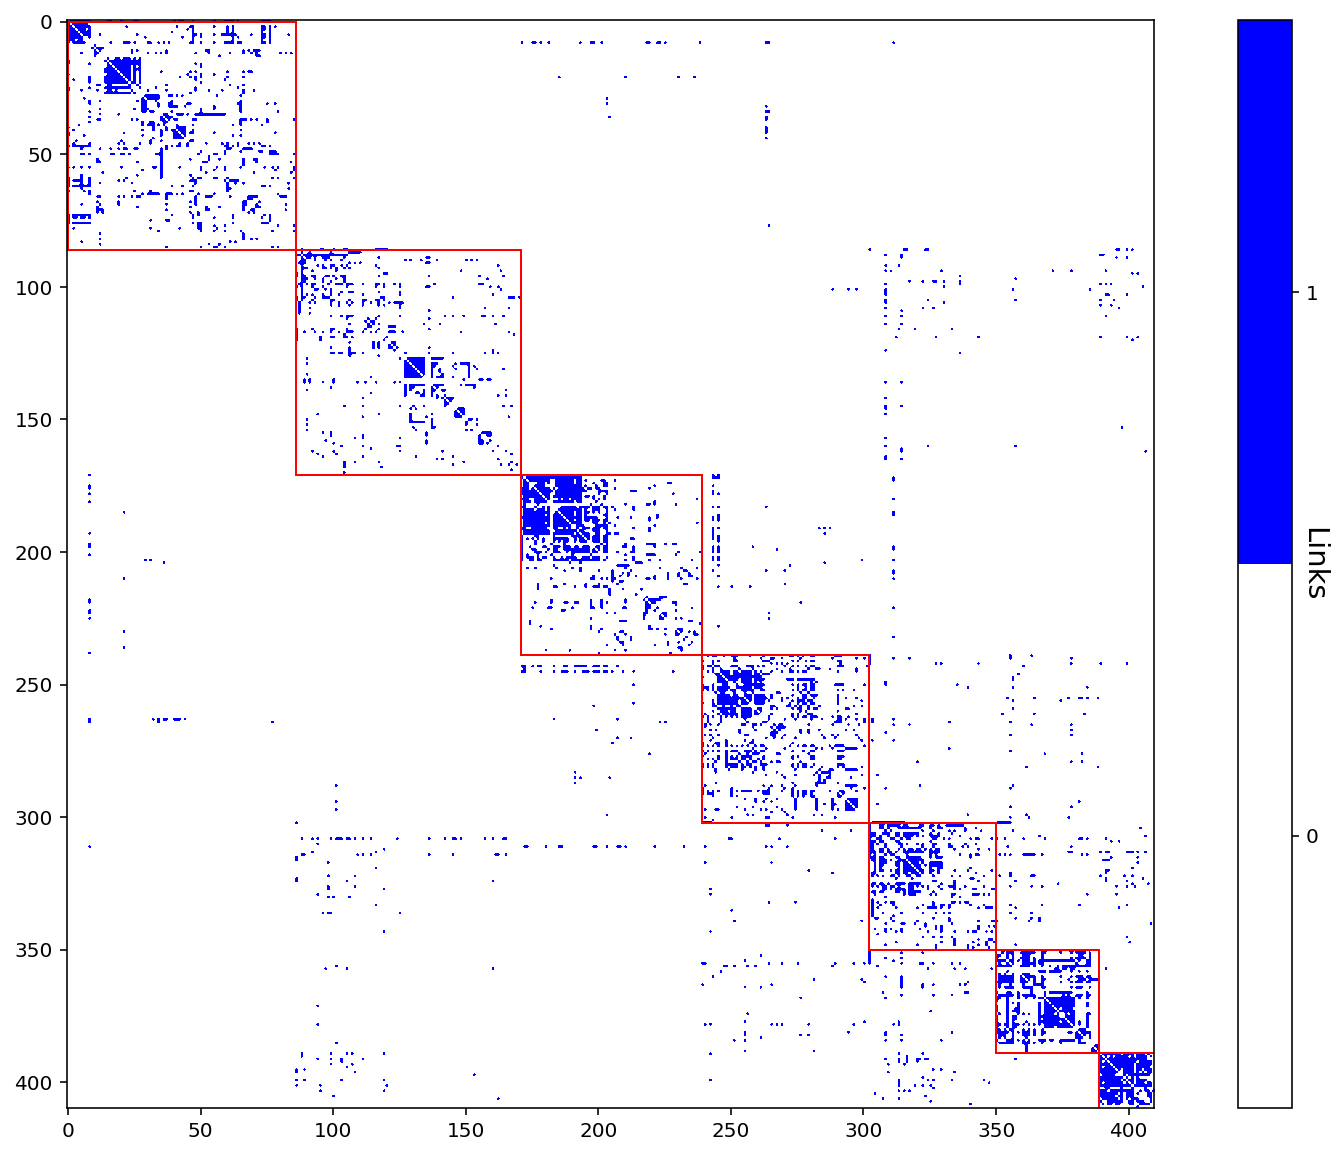

In [22]:
plot_adj_comm(Gx, community.best_partition(Gx))

## 3. SI Model

### 3.a SI Model

In [23]:
def SI_Model(G, initial_infects = [], beta = 0.5, t_simulation =100):
    '''
    Simulate the SI Model
    
    Parameters:
    ----------
    G: networkx graph
    initial_infects: list of node IDs that are infected initially
    beta: (float) probability of infection
    t_simulation: (int) simulation iteration time 
    
    returns: a dictionarry having nodes and their state ('S' for susceptible 'I' for infected)
    '''
    
    adj_mat = nx.to_numpy_array(G) # adjacency matrix of the graph G
    n_nodes = adj_mat.shape[0] # number of nodes
    is_infected = np.zeros(n_nodes)
    is_infected[initial_infects] = 1
    
    # initialize a dictionary containing all nodes and their respective state 'S' or 'I'
    states = {n+1:['S'] for n in range(n_nodes)}
    
    # probability of infection is 1 initially for initial infects and 0 for the rest of the nodes
    prob_infection = np.zeros(n_nodes)
    
    # probability of susceptibility is 1 initially except for those who are infected 0
    prob_susceptibility = np.ones(n_nodes)
    
    # this loop will initialize probability values for infected nodes
    for infected_initial_node in initial_infects: 
        prob_susceptibility[int(infected_initial_node - 1)] = 0 # node names start from 1 to 410 (-1 to index)
        prob_infection[int(infected_initial_node - 1)] = 1 
        states[infected_initial_node] = ['I'] # initialize the state of infected nodes in the dictionary

    
    for t in range(t_simulation):            
        for n in range(n_nodes):
            prob_infection[n] = prob_infection[n] + beta*prob_susceptibility[n]*sum(adj_mat[n,:]*prob_infection)
            prob_susceptibility[n] = 1 - prob_infection[n]
            
            if is_infected[n] == 0:
                # if not infected previously, update the dictionary
                if prob_infection[n] >= 0.5:
                    is_infected[n] = 1
                    states[n+1].append('I')
                else: 
                    states[n+1].append('S')
            else:
                states[n+1].append('I')
        
    rcParams['figure.figsize'] = (10,6)

    return states

In [24]:
def plot_sim(states_dict, title, t_simulation, model, line_style, 
             legend = {'S':'Susceptible', 'I':'Infected', 'R':'Recovered'},
             line_color = {'S':'r', 'I':'g', 'R':'y'}):
    '''Draw simulation results
    Parameters:
    ----------
    states_dict: a dictionary containing node IDs as keys and a list of state for each time step
    t_simulation: the number of iterations
    model: 'SI' or 'SIR'
    line_style: specifies the line style for the plot
    legend: dictionary having the states as keys and the respective labels
    line_color: dictionary having the states as keys and their respective line color for the plot
    '''
    
    for s in list(model):
        prev_count = 0
        list_count = []
        count = 0
        for n in range(t_simulation):
            for key, val in states_dict.items():
                if val[n] == s:
                    count +=1
            #         else: 
            list_count.append(count - prev_count)
            prev_count = count
        plt.plot([t for t in range(300)],list_count, ls = line_style, label = legend[s], color = line_color[s])
        plt.legend(fontsize='x-large')
    plt.title(title, fontsize = 'x-large')
    plt.xlabel('Simulation time', fontsize = 'x-large')
    plt.ylabel('Users', fontsize = 'x-large')

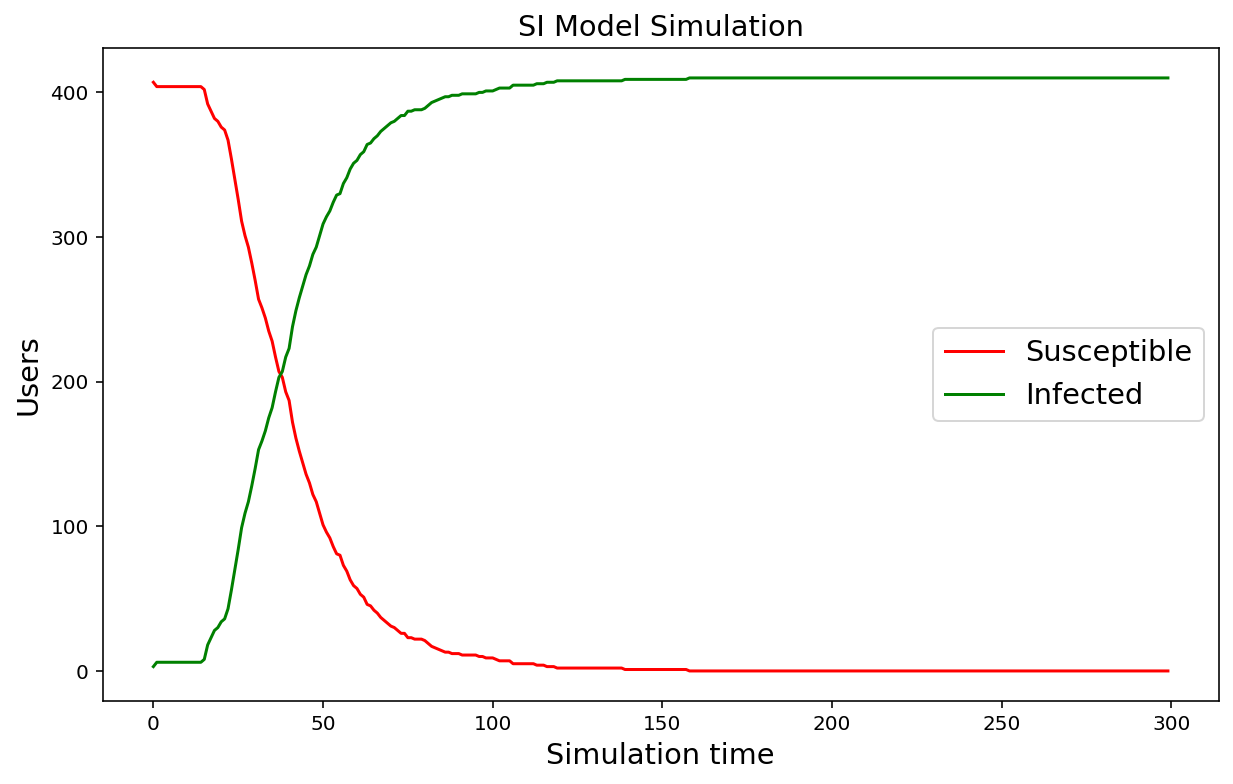

In [31]:
beta = 0.01
t_simulation = 300
initial_infects = np.random.randint(1, len(Gx.nodes()), 3)
vaccinated = np.random.randint(1, len(Gx.nodes())+1, 3)
SI_states = SI_Model(Gx, initial_infects=initial_infects, beta = beta, t_simulation=t_simulation)
plot_sim(SI_states, title = 'SI Model Simulation', t_simulation = t_simulation, model= 'SI', line_style='-')

### 3.b SIR Model

In [26]:
def SIR_Model(G, initial_infects, beta = 0.5, t_simulation =100, recovery_time = 15, vaccinated_nodes = []):
    '''Simulate SIR Model
    
    Parameters:
    ----------
    G: networkx graph
    initial_infects: list of node IDs that are infected initially
    beta: (float) probability of infection
    t_simulation: (int) simulation iteration time 
    recovery_time: (int) the number of days needed for the recovery
    vaccinated_nodes: a list of node IDs that are not affected by the infection
    
    returns: a dictionarry having nodes and their state ('S' for susceptible, 'I' for infected, 'R' for recovered)
    '''
    
    adj_mat = nx.to_numpy_array(G) # adjacency matrix of the graph G
    n_nodes = adj_mat.shape[0] # number of nodes
    number_infected_list = [len(initial_infects)]
    is_infected = np.zeros(n_nodes)
    is_infected[initial_infects] = 1
    
    # initialize a dictionary containing all nodes and their respective state 'S' or 'I'
    states = {n+1:['S'] for n in range(n_nodes)}
    for v in vaccinated_nodes:
        for t in range(t_simulation):
            states[v].append('S')
    # probability of infection is 1 initially for initial infects and 0 for the rest of the nodes
    prob_infection = np.zeros(n_nodes)
    
    # probability of susceptibility is 1 initially except for those who are infected 0
    prob_susceptibility = np.ones(n_nodes)
    
    # this loop will initialize probability values for infected nodes
    for infected_initial_node in initial_infects: 
        prob_susceptibility[int(infected_initial_node - 1)] = 0 # node names start from 1 to 410 (-1 to index)
        prob_infection[int(infected_initial_node - 1)] = 1 
        states[infected_initial_node] = ['I'] # initialize the state of infected nodes in the dictionary
        
    days_for_recovery = np.zeros(n_nodes)
    
    for t in range(t_simulation):            
        for n in range(n_nodes):
            if n+1 not in vaccinated_nodes:
                prob_infection[n] = prob_infection[n] + beta*prob_susceptibility[n]*sum(adj_mat[n,:]*prob_infection)
                prob_susceptibility[n] = 1 - prob_infection[n]
                
                if is_infected[n] == 0:
                    # if not infected previously, update the dictionary
                    if prob_infection[n] >= 0.5:
                        is_infected[n] = 1
                        states[n+1].append('I')
                    
                    # if infection probability is low, stay in 'S' state
                    else: 
                        states[n+1].append('S')
                        
                # if infected, check for recovery time        
                elif is_infected[n] == 1:   
                    # if condition holds, set state as 'R'
                    days_for_recovery[n] += 1
                    if days_for_recovery[n] == recovery_time:
                        is_infected[n] = 2 # 2 means recovered
                        states[n+1].append('R')  
                    else:
                        states[n+1].append('I')
                else:
                    states[n+1].append('R')
    

    return states

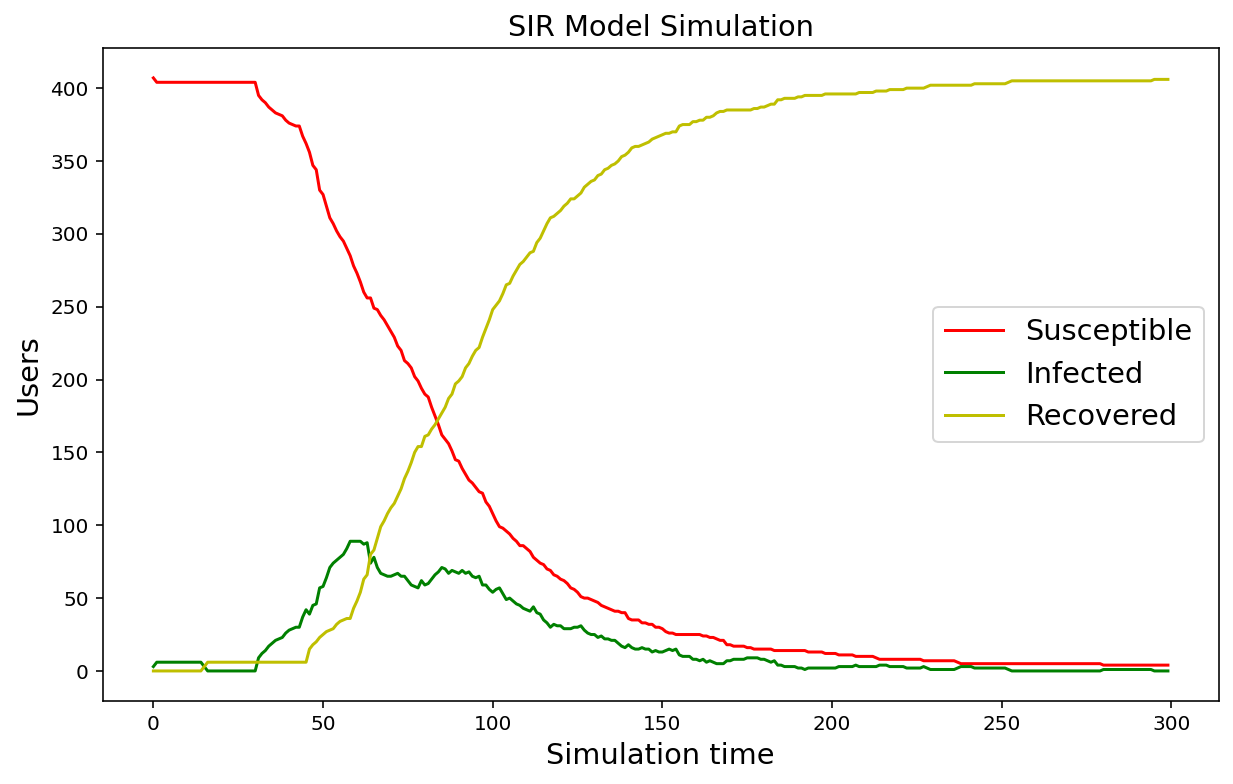

In [32]:
beta = 0.005
t_simulation = 300
recovery_time = 15
SIR_states = SIR_Model(Gx, 
                       initial_infects = initial_infects, 
                       beta = 0.005,
                       t_simulation = t_simulation, 
                       recovery_time = recovery_time,
                       vaccinated_nodes= vaccinated)
plot_sim(SIR_states, title = 'SIR Model Simulation', t_simulation = t_simulation, model= 'SIR', line_style='-')

### 3.c Second Wave

In [28]:
def SIR_Model_second_wave(G, initial_infects, beta = 0.5, t_simulation =100, recovery_time = 15, vaccinated_nodes = []):
    '''Simulate SIR Model
    
    Parameters:
    ----------
    G: networkx graph
    initial_infects: list of node IDs that are infected initially
    beta: (float) probability of infection
    t_simulation: (int) simulation iteration time 
    recovery_time: (int) the number of days needed for the recovery
    vaccinated_nodes: a list of node IDs that are not affected by the infection
    
    returns: a dictionarry having nodes and their state ('S' for susceptible, 'I' for infected, 'R' for recovered)
    '''
    
    adj_mat = nx.to_numpy_array(G) # adjacency matrix of the graph G
    n_nodes = adj_mat.shape[0] # number of nodes
    number_infected_list = [len(initial_infects)]
    is_infected = np.zeros(n_nodes) # 0: susceptible, 1: infected (first infection), 2: recovered, 3: infected (second)
    is_infected[initial_infects] = 1 
    
    # initialize a dictionary containing all nodes and their respective state 'S' or 'I'
    states = {n+1:['S'] for n in range(n_nodes)}
    for v in vaccinated_nodes:
        for t in range(t_simulation):
            states[v].append('S')
    # probability of infection is 1 initially for initial infects and 0 for the rest of the nodes
    prob_infection = np.zeros(n_nodes)
    
    # probability of infection for the second wave, initialize 30 nodes later to 1 (at t=100)
    prob_infection2 = np.zeros(n_nodes)
    
    # probability of susceptibility is 1 initially except for those who are infected 0
    prob_susceptibility = np.ones(n_nodes)
    prob_susceptibility2 = np.ones(n_nodes)
    # this loop will initialize probability values for infected nodes
    for infected_initial_node in initial_infects: 
        prob_susceptibility[int(infected_initial_node - 1)] = 0 # node names start from 1 to 410 (-1 to index)
        prob_infection[int(infected_initial_node - 1)] = 1 
        states[infected_initial_node] = ['I'] # initialize the state of infected nodes in the dictionary
        
    
    days_for_recovery = np.zeros(n_nodes)
    
    '''This block of code executes the second wave by changing beta to a larger value and
    select 30 random nodes to be infected (we also check their states before proceeding 
    with r3434)
    ******************************'''
    for t in range(t_simulation):
        if t == 100:
            beta2 = 0.02
            second_wave_nodes = np.random.randint(0,n_nodes,30)
            
            for swn in second_wave_nodes:
                if is_infected[swn] != 2:
                    prob_infection2[swn] = 1
                    prob_susceptibility2[swn] = 0
                    if is_infected[swn] == 0:
                        is_infected[swn] = 1
                    elif is_infected[swn] == 1:
                        days_for_recovery[swn] = 0
        
        # same execution as in initial SIR implementation, only some 
        for n in range(n_nodes):
            if n+1 not in vaccinated_nodes:
                
                # start second wave infection, and compute a separate infecation probability for second wave
                if t >= 100:
                    prob_infection2[n] = prob_infection2[n] + beta2*prob_susceptibility2[n]*sum(adj_mat[n,:]*prob_infection2)
                    prob_susceptibility2[n] = 1 - prob_infection2[n]
                    
                prob_infection[n] = prob_infection[n] + beta*prob_susceptibility[n]*sum(adj_mat[n,:]*prob_infection)
                prob_susceptibility[n] = 1 - prob_infection[n]
                
                if is_infected[n] == 0:
                    # if not infected previously, update the dictionary, and set infected if threashold is passed
                    if t >= 100:
                        if prob_infection2[n] >= 0.5:
                            is_infected[n] = 3
                            states[n+1].append('I')
                        else:
                            if prob_infection[n] >= 0.5:
                                is_infected[n] = 1
                                states[n+1].append('I')
                                
                            # if infection probability is low, stay in 'S' state
                            else: 
                                states[n+1].append('S')
                    # this is run before the 100th simulation time unit
                    else:
                        if prob_infection[n] >= 0.5:
                            is_infected[n] = 1
                            states[n+1].append('I')

                        # if infection probability is low, stay in 'S' state
                        else: 
                            states[n+1].append('S')
                        
                # if infected, check first if probability of second infection is high
                elif is_infected[n] == 1: 
                    days_for_recovery[n] += 1
                    if t >= 100:
                        if prob_infection2[n] >= 0.5:
                            is_infected[n] = 3
                            states[n+1].append('I')
                            days_for_recovery[n] = 0
                        # if condition holds, set state as 'R'
                        elif days_for_recovery[n] == recovery_time:
                            is_infected[n] = 2 # 2 means recovered
                            states[n+1].append('R')  
                        else:
                            states[n+1].append('I')
                    else:
                        if days_for_recovery[n] == recovery_time:
                            is_infected[n] = 2 
                            states[n+1].append('R')  
                        else:
                            states[n+1].append('I')

                elif is_infected[n] == 3:
                    days_for_recovery[n] += 1
                    if days_for_recovery[n] == recovery_time:
                        is_infected[n] = 2 
                        states[n+1].append('R')
                    else: states[n+1].append('I')
                else:
                    states[n+1].append('R')

    return states

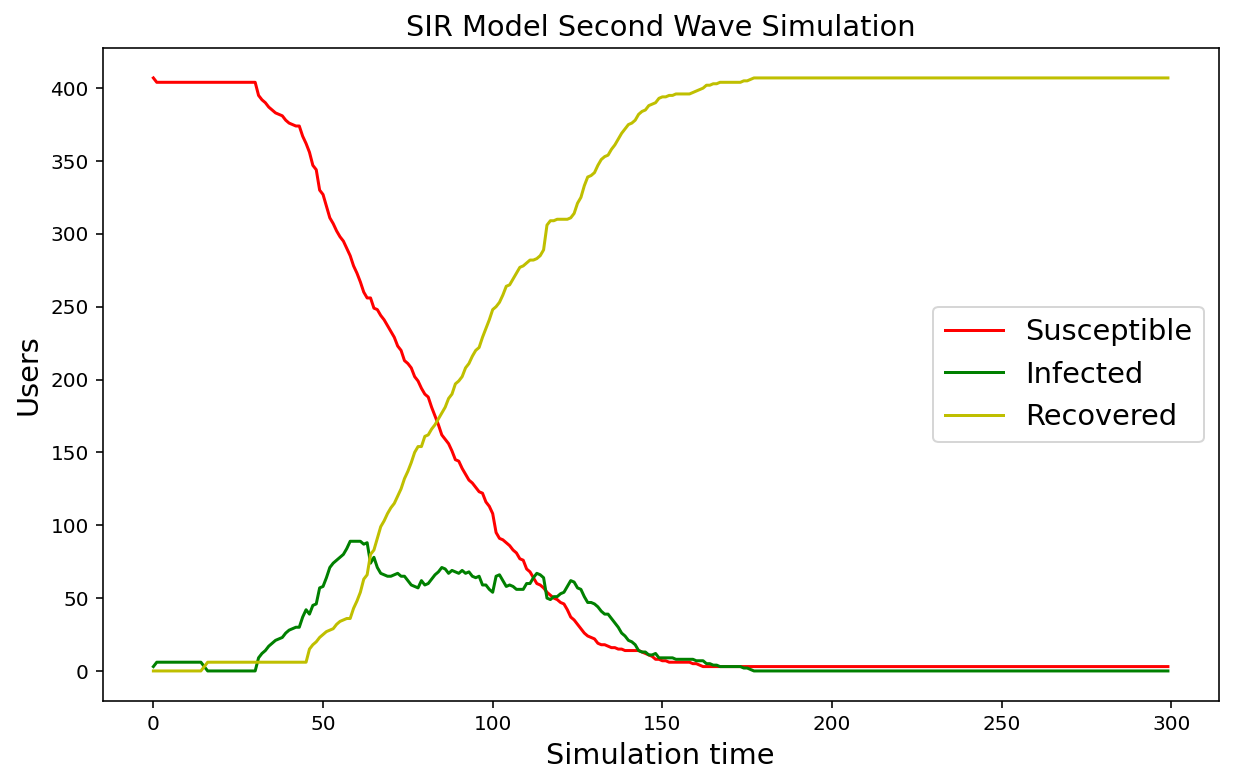

In [33]:
SIR_second_states = SIR_Model_second_wave(Gx, 
                       initial_infects = initial_infects, 
                       beta = beta,
                       t_simulation = t_simulation, 
                       recovery_time = recovery_time,
                       vaccinated_nodes= vaccinated)
plot_sim(SIR_second_states, title = 'SIR Model Second Wave Simulation', t_simulation = t_simulation, model= 'SIR', line_style='-')

### 3.c Remarks

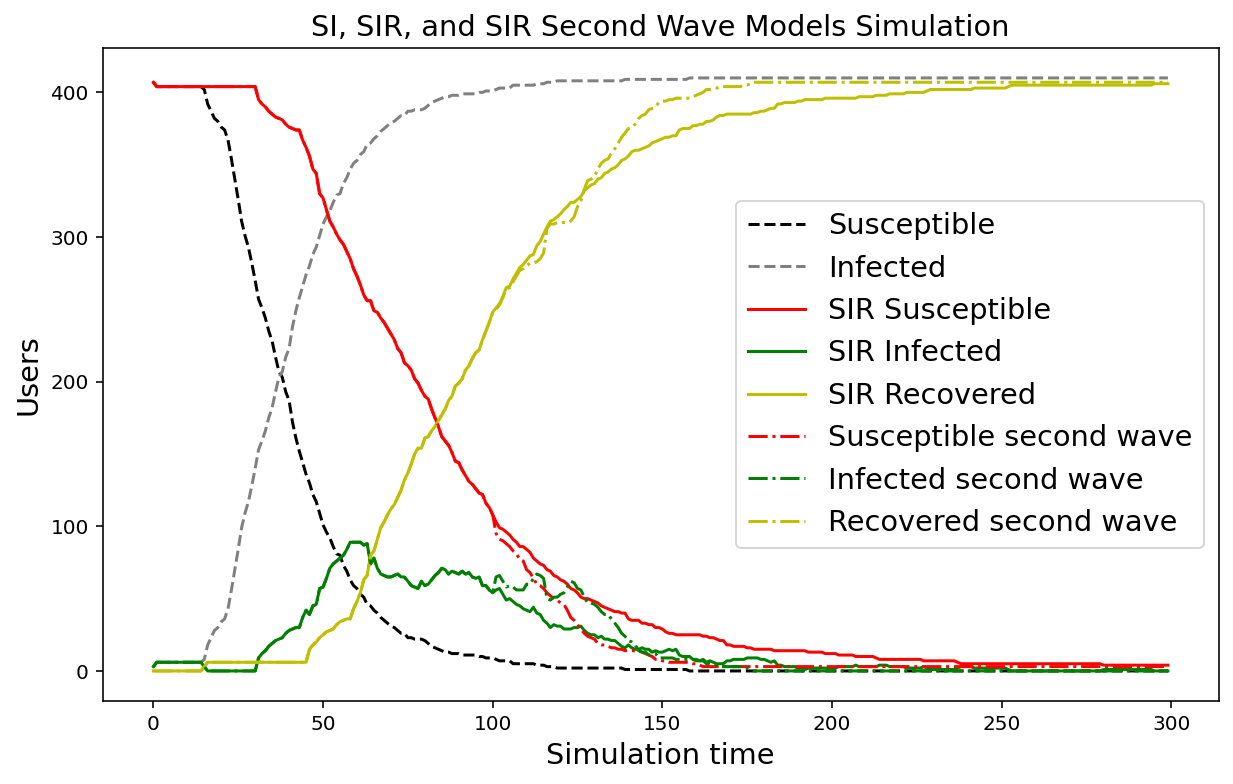

In [34]:
plot_sim(SI_states, 
         title = '',
         t_simulation = t_simulation, 
         model= 'SI', 
         line_style='--',
        line_color={'S': 'black', 'I': 'gray'})
plot_sim(SIR_states, 
         title = '',
         t_simulation = t_simulation, 
         model= 'SIR',
         legend = {'S':'SIR Susceptible', 'I':'SIR Infected', 'R':'SIR Recovered'},
         line_style='-')
plot_sim(SIR_second_states, 
         title = 'SI, SIR, and SIR Second Wave Models Simulation', 
         t_simulation = t_simulation,
         model= 'SIR', 
         legend = {'S':'Susceptible second wave', 'I':'Infected second wave', 'R':'Recovered second wave'},
         line_style='-.')

For SI model, we can see the the number of infections is raising rapidely (decrease in the number of susceptible users) due to the high infection probability 0.01 (compared to SIR). The SIR Model shows an initial increase in the number of infected users then the number decreases after each node passes 15 simulation time units and turn to a recovered state. For SIR second wave, after 100 days we notice another increase in the number of infections due to the second infection (please note that the first infection keeps spreading and we computed two different infection probabilities for the first and second wave, giving the second wave the highest priority). The increase in infections after day 100 is faster than the fist one due to the high probability of infection of the second wave. We can also see that the number of recovered users after day 100 is less than the first SIR simulation then continue to increase. We can also see the fast drop in susceptible after day 100 compared to the previous SIR simulation due to the faster spread (beta = 0.02).